# Game of Drones on a Graph (0-7) - Section IV Formal Model

This section formalises the Game of Drones on a Graph by introducing a common structural model shared by both adversarial variants. Subsection IV-A presents the underlying graph-based version, including the cost vector formulation, risk assignments. Subection IV-B introduces the concept of lexicographic ordering as a realistic and operationally justified method to prioritise drone paths. Finally, subsections IV-C and IV-D then specify the normal-form and Stackelberg variants, respectively.

In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import scipy.optimize
import latexify

print(f"Packages loaded with following versions\n\tJSON\t\t\t- {json.__version__}\n\tNetworkx\t\t- {nx.__version__}\n\tLatexify version\t- {latexify.__version__}")

Packages loaded with following versions
	JSON			- 2.0.9
	Networkx		- 3.5
	Latexify version	- 0.4.4


## IV-A Shared Graph 

Representation of a strategic game between a jammer and a drone on a graph. The graph represents a complex urban environment where the drone needs to navigate from a start to a target node.

The graph is defined as $G=(V,E)$ with the nodes reflecting decision points and the edges represent distances between the nodes. 


## Generate the Graph G from JSON file

This code presupposes the availability of a JSON file which defines the graph. For this paper, we use the following JSON definition:

{
  "directed": false,
  "multigraph": false,
  "graph": {},
  "nodes": [
    {"id": "1", "label": "1", "color": "green"},
    {"id": "2", "label": "2", "color": "gray"},
    {"id": "3", "label": "3", "color": "gray"},
    {"id": "4", "label": "4", "color": "gray"},
    {"id": "5", "label": "5", "color": "gray"},
    {"id": "6", "label": "6", "color": "gray"},
    {"id": "7", "label": "7", "color": "maroon"}
  ],
  "links": [
    {"source": "1", "target": "2", "R": 0, "L": 1},
    {"source": "1", "target": "4", "R": 0, "L": 1},
    {"source": "1", "target": "5", "R": 0, "L": 1},
    {"source": "2", "target": "3", "R": 0, "L": 1},
    {"source": "2", "target": "4", "R": 0, "L": 1},
    {"source": "3", "target": "7", "R": 0, "L": 1},
    {"source": "4", "target": "5", "R": 0, "L": 1},
    {"source": "4", "target": "6", "R": 0, "L": 1},
    {"source": "5", "target": "6", "R": 0, "L": 1},
    {"source": "6", "target": "7", "R": 0, "L": 1}
  ],
  "positions": {
    "1": [1.0, 1.0],
    "2": [2.0, 2.0],
    "3": [3.0, 2.0],
    "4": [2.0, 1.0],
    "5": [2.0, 0.0],
    "6": [3.0, 0.0],
    "7": [4.0, 1.0]
  }
}

**In summary**: the graph has colored nodes showing start (green) and target (maroon), where all navigable nodes are gray. Edge length is supposed to be unity for all edges, although the code allows changes of these edge lengths.

This JSON model is extended by including a separate dictionary 'positions', which contains the coordinates for NETWORKX to display the nodes in an image.


In [2]:
# define parameters
json_file = 'GoD_basic_graph.json'
B = 5
jammer_nodes = ["2", "3", "4", "5", "6"] 
edge_risk = 0.5


# load a Graph from a JSON file, 
with open(json_file, 'r') as f:
    data = json.load(f)

G = nx.node_link_graph(data, edges="links")


# Access the attributes of nodes and edges:
print("Node attributes:")
for node, attrs in G.nodes(data=True):
    print(f"{node}: {attrs}")

print("\nEdge attributes:")
for u, v, attrs in G.edges(data=True):
    print(f"{u}->{v}: {attrs}")


# Draw the graph
def show_graph(graph, title="Game of Drones - basic graph, no jammer", save_to_file=False):
    node_labels = nx.get_node_attributes(graph, 'label')
    node_colors = [attrs['color'] for node, attrs in graph.nodes(data=True)]

    # Show risk and length on each edge
    edge_labels = {(u, v): f"R={attrs['R']}\nL={attrs['L']}" 
                   for u, v, attrs in graph.edges(data=True)}

    # Get positions and colors from JSON 'data'
    networkx_pos = {node_id: tuple(coords) for node_id, coords in data['positions'].items()}
#    node_colors = [node["color"] for node in data["nodes"]]

    nx.draw_networkx(graph, pos=networkx_pos, with_labels=True, labels=node_labels, 
                     node_color=node_colors, node_size=1000, font_size=10)

    nx.draw_networkx_edge_labels(graph, pos=networkx_pos, edge_labels=edge_labels)

    plt.title(title)

    plt.gca().set_frame_on(False)
    if save_to_file:
        plt.savefig(f"Fig_{title}.png", bbox_inches='tight', facecolor='white')
    plt.show()


Node attributes:
1: {'label': '1', 'color': 'green'}
2: {'label': '2', 'color': 'gray'}
3: {'label': '3', 'color': 'gray'}
4: {'label': '4', 'color': 'gray'}
5: {'label': '5', 'color': 'gray'}
6: {'label': '6', 'color': 'gray'}
7: {'label': '7', 'color': 'maroon'}

Edge attributes:
1->2: {'R': 0, 'L': 1}
1->4: {'R': 0, 'L': 1}
1->5: {'R': 0, 'L': 1}
2->3: {'R': 0, 'L': 1}
2->4: {'R': 0, 'L': 1}
3->7: {'R': 0, 'L': 1}
4->5: {'R': 0, 'L': 1}
4->6: {'R': 0, 'L': 1}
5->6: {'R': 0, 'L': 1}
6->7: {'R': 0, 'L': 1}


## Fig. 3 Show the graph

Any graph in this code can be displayed with the same basic function 'show_graph'. When a basic graph $G$ is modified by assigning a jammer node to one of the nodes in [2,3,4,5,6], a number of changes is applied:

    * Node color - the color of the jammer node is changed from 'gray to 'red' to indicate the jammer location
    * Edge risks - all edges connected to the jammer node change from their basic value r=0.0 to r=0.5
    * Graph Title - adjusted to reflect the chosen jammer node.

The following code shows the basic graph. Later in this notebook we will show a modified graph with a jammer node selected.

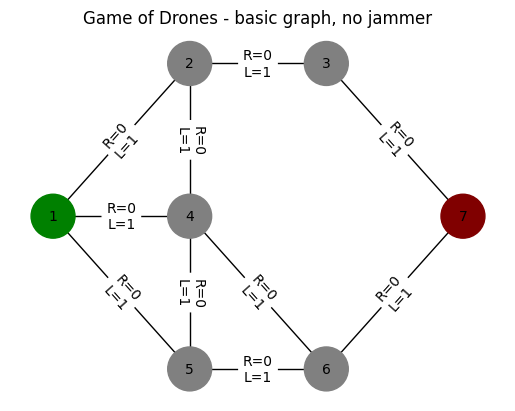

In [3]:
show_graph(G, save_to_file=True)

## Section V-A: List of viable paths

The list of viable paths comprises all paths from start node to finish node with a length < maximum range of the drone (B). The NETWORKX package allows finding *all simple paths* (so no recurring nodes) with a length <= cutoff. 

The next cell generates 'all simple paths' from graph G, so a list of all paths where each node is traversed no more than once. From this list of total_paths we extract all paths shorter or equal to 'B', the max range of the drone in terms of edges, the so-called list of 'viable paths'.

Finally, we export the list of 'total_paths' in LaTeX format to the file 'TabII_Simple_Paths.txt' for inclusion as Table II 'Simple Paths' in section V-A

In [4]:
# generate a text file for Table II Simple Paths in section V-A
def generate_latex_table_from_all_paths(total_paths, G, outfile="TabII_Simple_Paths.txt"):
    success = False
    with open(outfile, "w") as f:
        f.write("\\begin{table} [ht!] \n")
        f.write("\\renewcommand{\\arraystretch}{1.2} \n")
        f.write("\\caption{Simple paths from S to T for graph in Fig.~\\ref{fig:ExampleGraph}} \n")
        f.write("\\label{tab:SimplePathsExample} \n")
        f.write("\t\\centering \n")
        f.write("\t\\begin{tabular}{c c c} \\toprule \n")
        f.write("\t\\textbf{Path ID} & \\textbf{Route} & \\textbf{Length} \\\\ \\midrule \n")

        for idx, path in enumerate(total_paths, 1):
            # Format path string as "1–2–3–7"
            route = "–".join(path)

            # Compute path length based on edge weights
            path_length = sum(G.edges[u, v]['L'] for u, v in zip(path[:-1], path[1:]))

            # Write table row
            f.write(f"\t\t{idx} & {route} & {path_length} \\\\ \n")

            # Insert midrule after every 4 paths
            if idx % 4 == 0:
                f.write("\t\t\\midrule \n")

        f.write("\t\t\\bottomrule \n")
        f.write("\t\\end{tabular} \n")
        f.write("\\end{table}")
        success = True
    return (success, outfile)   
    

In [5]:
# get the list of simple paths from start=1 to target=7 on graph G:
total_paths = list(nx.all_simple_paths(G, "1", "7"))

success, tabIIfile = generate_latex_table_from_all_paths(total_paths, G)
if success:
    print(f"\nData for Table II succesfully captured in file {tabIIfile}")

# now generate the list of viable paths, so paths with number of edges <= B:
print("\n*** Viable Paths in G ***")
viable_paths = [p for p in total_paths if sum(G.edges[u, v]['L'] for u, v in zip(p[:-1], p[1:])) < B+1]
count = 1
for p in viable_paths:
    print(f"[{count}] - length = {len(p)} - path is {p}")
    count+=1



Data for Table II succesfully captured in file TabII_Simple_Paths.txt

*** Viable Paths in G ***
[1] - length = 4 - path is ['1', '2', '3', '7']
[2] - length = 6 - path is ['1', '2', '4', '5', '6', '7']
[3] - length = 5 - path is ['1', '2', '4', '6', '7']
[4] - length = 5 - path is ['1', '4', '2', '3', '7']
[5] - length = 5 - path is ['1', '4', '5', '6', '7']
[6] - length = 4 - path is ['1', '4', '6', '7']
[7] - length = 6 - path is ['1', '5', '4', '2', '3', '7']
[8] - length = 5 - path is ['1', '5', '4', '6', '7']
[9] - length = 4 - path is ['1', '5', '6', '7']


## Section V-A Graph updating due to jammer

With a jammer present at a certain node $j$, we can modify our base graph $G$ through the following function. The title is automatically adjusted to the selected jammer node.

In [6]:
# Copy graph G and use jammer node to update edges of new jammerG
def apply_jammer_to_graph(baseG, jammer_node, risk_value=0.5, show=False, save=False):
    """Return a copy of G_in with risk applied to jammer-connected edges."""
    
    # copy the base graph to the new output graph:
    jammerG = baseG.copy()

    # update the edges with the risk from the jammer node:
    for u, v in jammerG.edges():
        jammerG.edges[u, v]['R'] = risk_value if jammer_node in (u, v) else 0.0

    # change the jammer node color to red:
    jammerG.nodes[jammer_node]['color'] = 'red'

    if show:
        if save:
            show_graph(jammerG, title=f"Game of Drones - jammer at node = {jammer_node}", save_to_file=True)
        else:
            show_graph(jammerG, title=f"Game of Drones - jammer at node = {jammer_node}")
        
    return jammerG

As announced earlier, any modified graph can be displayed by key-value pair 'show=True' in the function call:

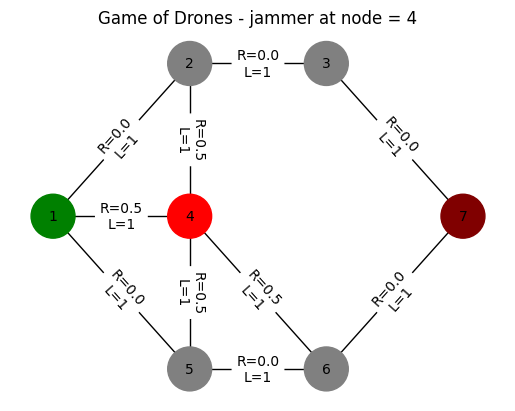

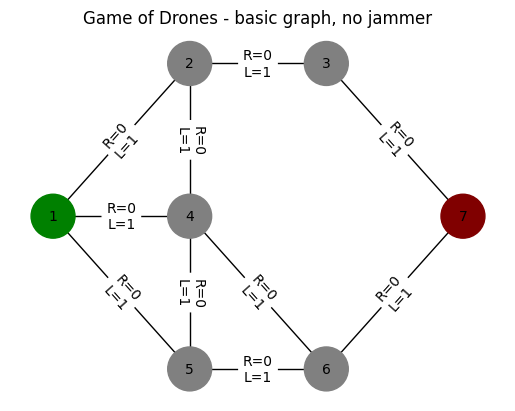

In [7]:
# Modify base graph G with jammer at "4" and show/save the graph:
apply_jammer_to_graph(G, "4", show=True, save=True)

# Modify base graph G with jammer at "3", save it but don't show:
apply_jammer_to_graph(G, "3", save=True)

# Verify the base graph is still unchanged:
show_graph(G)

### Game results (paths versus jammer nodes) 

In this approach, we calculate the actual (bi-variate) utility u(p,j) = (risk, length) for each combination of path and jammer node. 

The overall mission risk for a particular path is the compounded risk from the individual edges composing this path, calculated as follows:
\begin{equation}
	  R(p,j) = 1 - \prod_{e \in p} \left( 1 - r^{(j)}(e) \right).
\end{equation}
with path length defined as
\begin{equation}
	L(p) = \sum_{e_{uv} \in p} l(e_{uv}). 
\end{equation}


The utility matrix is turned into the **payoff matrix** by applying lexicographic ordering. Through LexOrd, we map the bi-variate utilities onto a single scalar scale, ranking the utility primarily in order of risk, with length as tie-breaker. We use equation 31 from the paper, with $\gamma=1000$ and $B=5$:

\begin{equation}
    u(p,j) = 
    \begin{cases}
            - \frac{\gamma R^{(j)}(p) + L(p)}{\gamma + B} & \text{if } L(p) \leq B  \\
            - \infty & \text{otherwise}
    \end{cases}
\end{equation}



In [8]:
def compute_path_utility(path, jammedG):
    success = 1
    length = 0

    for u, v in zip(path[:-1], path[1:]):
        length += jammedG.edges[u, v]['L']
        success *= (1 - jammedG.edges[u, v]['R'])

    # Lexicographic utility: min risk, then min length
    return (1-success, length)

In [9]:
# Calculate V(r,l), so the lexord value for a utility u(p,j)
def Vlexord(risk, length, gamma=1000, B=5):
    return( (-1*gamma*risk-length) / (gamma + B))

With the updated graph *jammedG* we can now calculate the utilities $u(p,j)$ for each path and each possible jammer node. These utilities are bi-variate as these are tuples $(risk, length)_{(p,j)}$. 

The utility matrix is generated as follows:

In [10]:
# calculate utility matrix from viable paths and jammedG:
def generate_utility_matrix(viable_paths, jammer_nodes, G_base):

    # Initialize matrices as column-wise lists (later transpose)
    U_matrix_cols = []

    for jammer_node in jammer_nodes:
        G_mod = apply_jammer_to_graph(G_base, jammer_node)

        U_col = []
        for path in viable_paths:
            edge_risks = [G_mod.edges[u, v]['R'] for u, v in zip(path[:-1], path[1:])]
            edge_lengths = [G_mod.edges[u, v]['L'] for u, v in zip(path[:-1], path[1:])]

            risk = 1 - np.prod([1 - r for r in edge_risks])
            length = sum(edge_lengths)

            U_col.append((risk, length))

        U_matrix_cols.append(U_col)

    # Transpose columns to row-wise layout: paths as rows
    U_matrix = list(map(list, zip(*U_matrix_cols)))

    return U_matrix

# convert the utility matrix to the payoff matrix via lexord conversion:
def generate_payoff_matrix_from_utility_matrix(utility_matrix):

    V_matrix = []

    nr_rows = len(utility_matrix)
    nr_cols = len(utility_matrix[0])

    for r in np.arange(nr_rows):
            V_row = [ Vlexord(utility_matrix[r][c][0], utility_matrix[r][c][1]) for c in np.arange(nr_cols)]
            V_matrix.append(V_row)
    return V_matrix

In [11]:
# Generate the utility matrix for all viable paths and all possible jammer nodes on G:
utility_matrix = generate_utility_matrix(viable_paths, jammer_nodes, G)

# convert utility matrix to payoff_matrix:
payoff_matrix = generate_payoff_matrix_from_utility_matrix(utility_matrix)

## Export Utility and Payoff matrix to tables

The utility matrix is an essential part of the analysis section in the paper. The following two functions extract LaTeX tables from the utility matrix, as follows:

    * Table III - Utility Matrix showing (risk, length) for each path/jammer pair
    * Table IV - Value or Payoff Matrix showing lexord value of each (risk,)

The following two functions produce a text file with the proper LATEX code for these two tables.

In [12]:
# generate a text file for Table III Risk Matrix  R(p,j) in section V-A
def generate_latex_table_from_utility_matrix(utility_matrix,
                                             total_paths, viable_paths,
                                             jammer_nodes, 
                                             outfile="TabIII_Utility_Matrix.txt"):
    success = False
    with open(outfile, "w") as f:

        f.write("\\begin{table} [ht!] \n")
        f.write("\\renewcommand{\\arraystretch}{1.2} \n")
        f.write("\\caption{Risk Matrix $R(p,j)$} \n")
        f.write("\\label{tab:RiskMatrix} \n")
        f.write("\t\\centering \n")
        f.write("\t\\begin{tabular}{c l l l l l} \\toprule \n")
        f.write("\t\\textbf{Path ID} & j=2 & j=3 & j=4 & j=5 & j=6 \\\\ \\midrule \n")

        nr_rows = len(viable_paths)
        nr_cols = len(jammer_nodes)

        for r in np.arange(nr_rows):
            idx = total_paths.index(viable_paths[r])
            outline = f"{idx+1}"
            
            for c in np.arange(nr_cols):
                risk = f"{float(utility_matrix[r][c][0]):2.2f}"
                #print(f"r:{r}, c:{c}, U:{utility_matrix[r][c][0]:2.2f}, risk:{risk}")
                outline += " & " + risk
            f.write(f"\t{outline} \\\\ \n")
        
        f.write("\t\\bottomrule \n")
        f.write("\t\\end{tabular} \n")
        f.write("\\end{table}")
        success = True
    return (success, outfile)


In [13]:
# generate a text file for Table IV Payoff U(p,j) in section V-A
def generate_latex_table_from_payoff_matrix(u_matrix,
                                            total_paths, viable_paths,
                                            jammer_nodes, 
                                            outfile="TabIV_Payoff_Matrix.txt"):
    success = False
    with open(outfile, "w") as f:

        f.write("\\begin{table} [ht!] \n")
        f.write("\\renewcommand{\\arraystretch}{1.2} \n")
        f.write("\\caption{Normalised Payoff matrix $u(p,j)$ using lexicographic utility with $\gamma=1000$ and $B=5$.} \n")
        f.write("\\label{tab:UtilityMatrix} \n")
        f.write("\t\\centering \n")
        f.write("\t\\begin{tabular}{c l l l l l} \\toprule \n")
        f.write("\t\\textbf{Path ID} & j=2 & j=3 & j=4 & j=5 & j=6 \\\\ \\midrule \n")

        nr_rows = len(viable_paths)
        nr_cols = len(jammer_nodes)

        for r in np.arange(nr_rows):
            idx = total_paths.index(viable_paths[r])
            outline = f"{idx+1}"
            
            for c in np.arange(nr_cols):
                payoff = f"{Vlexord(u_matrix[r][c][0], u_matrix[r][c][1]):2.3f}"
                outline += " & " + payoff
            f.write(f"\t{outline} \\\\ \n")
        
        f.write("\t\\bottomrule \n")
        f.write("\t\\end{tabular} \n")
        f.write("\\end{table}")
        success = True
    return (success, outfile)


In [14]:
# turn utility matrix into table III for the paper
succes, outfile = generate_latex_table_from_utility_matrix(utility_matrix, 
                                                           total_paths, viable_paths, 
                                                           jammer_nodes)
if success:
    print(f"Table III successfully generated with filename: {outfile}")

# turn payoff matrix into table IV for the paper
succes, outfile = generate_latex_table_from_payoff_matrix(utility_matrix, 
                                                          total_paths, viable_paths, 
                                                          jammer_nodes)
if success:
    print(f"Table IV successfully generated with filename: {outfile}")

Table III successfully generated with filename: TabIII_Utility_Matrix.txt
Table IV successfully generated with filename: TabIV_Payoff_Matrix.txt


## Game analysis

The availability of the payoff matrix allows further analysis of the game. Focus may be on:

    * Dominant Strategies
    * Nash Equilibria
    * Mixed Strategies

### 1 - Dominant strategies


In [15]:
def find_strictly_dominated_strategies(payoff_matrix, player='row'):
    """
    Identifies strictly dominated strategies for either the row or column player.
    Returns a list of indices that are strictly dominated.

    Parameters:
        V_matrix : list[list[float]]
            Payoff matrix where rows = drone paths, columns = jammer nodes.
        player : 'row' or 'col'

    Returns:
        dominated : list of indices (int)
    """
    V = np.array(payoff_matrix)
    strictly_dominated = []

    if player == 'row':
        for i in range(V.shape[0]):
            for j in range(V.shape[0]):
                if i != j and all(V[i, :] < V[j, :]):
                    strictly_dominated.append(i)
                    break

    elif player == 'col':
        for i in range(V.shape[1]):
            for j in range(V.shape[1]):
                if i != j and all(V[:, i] > V[:, j]):
                    strictly_dominated.append(i)
                    break

    return strictly_dominated

In [16]:
dominated_path_strategies = find_strictly_dominated_strategies(payoff_matrix, player='row')
if dominated_path_strategies:
    print(f"The analysis found the following path strategies to be dominated : {dominated_path_strategies}")
else:
    print("Analysis has not found any dominated strategies for the drone")

dominated_jammer_strategies = find_strictly_dominated_strategies(payoff_matrix, player='col')
if dominated_jammer_strategies:
    print(f"The analysis found the following jammer strategies to be dominated : {dominated_jammer_strategies}")
else:
    print("Analysis has not found any dominated strategies for the jammer")


The analysis found the following path strategies to be dominated : [1, 2, 3, 4, 6, 7]
Analysis has not found any dominated strategies for the jammer


As dominated strategies will not be part of the support for the game's solution anymore, we can remove these

In [17]:
def compute_dominating_rows(V_matrix):
    """
    For each row i in the payoff matrix, identifies all other rows j that are strictly dominated by i.
    
    Parameters:
        V_matrix : list[list[float]]
            Payoff matrix (drone strategies as rows)

    Returns:
        domination_dict : dict
            domination_dict[i] = [j1, j2, ...] where i strictly dominates each j
    """
    V = np.array(V_matrix)
    n_rows = V.shape[0]
    domination_dict = {}

    for i in range(n_rows):
        dominating_row = V[i]
        dominated = []

        for j in range(n_rows):
            if i == j:
                continue
            target_row = V[j]

            if np.all(dominating_row > target_row):
                dominated.append(j)

        if dominated:
            domination_dict[i] = dominated

    return domination_dict


# now export the domination table to the paper
def export_dominating_strategies_to_latex(domination_dict, V_matrix, outfile="TabV_DominationTable.txt"):
    success = False
    with open(outfile, "w") as f:
        f.write("\\begin{table} [ht!]\n")
        f.write("\\centering\n")
        f.write("\\caption{Path domination based on strict lexicographic payoff comparison}\n")
        f.write("\\label{tab:DominatingStrategies}\n")
        f.write("\\begin{tabular}{c | l}\n")
        f.write("\\toprule\n")
        f.write("Path ID & Dominated Paths \\\\\n")
        f.write("\\midrule\n")

        for i, dominated_rows in domination_dict.items():
            row_id = i + 1
            dominated_str = ", ".join(str(j + 1) for j in dominated_rows)
            f.write(f"{row_id} & {dominated_str} \\\\\n")

        f.write("\\bottomrule\n")
        f.write("\\end{tabular}\n")
        f.write("\\end{table}\n")
        success = True
    return success, outfile


In [18]:
domination_path = compute_dominating_rows(payoff_matrix)

if domination_path:
    for dom_idx, dom_list in domination_path.items():
        print(f"Row {dom_idx+1} dominates rows: {', '.join(str(j+1) for j in dom_list)}")

success, outfile = export_dominating_strategies_to_latex(domination_path, payoff_matrix)
if success:
    print(f"Table IV successfully generated with filename: {outfile}")
else:
    print("No Table IV text file could be generated")


Row 1 dominates rows: 4, 7
Row 3 dominates rows: 2
Row 4 dominates rows: 7
Row 5 dominates rows: 2
Row 6 dominates rows: 2, 3, 5, 8
Row 8 dominates rows: 2
Row 9 dominates rows: 2, 5, 8
Table IV successfully generated with filename: TabV_DominationTable.txt


This table of dominating strategies can be condensed into a list of three strategies dominating all others: $[1,6, 10 ]$. Consequentially, any mixed strategy solutions are based on probability densities over this set of dominating strategies.


### 2 - Pure strategy equilibria (Saddle Points)

After analysis of dominant strategies, we now evaluate the payoff_matrix for the existence of any pure strategy equilibria (Nash Equilibrium).

In [19]:
def find_pure_strategy_nash_equilibria(V_matrix):
    V = np.array(V_matrix)
    n_rows, n_cols = V.shape
    equilibria = []

    for i in range(n_rows):
        for j in range(n_cols):
            if V[i, j] == V[i, :].min() and V[i, j] == V[:, j].max():
                equilibria.append((i, j))

    return equilibria


In [20]:
pure_nash_eq = find_pure_strategy_nash_equilibria(payoff_matrix)

if pure_nash_eq:
    for i, j in pure_nash_eq:
        print(f"Pure NE at path {i+1}, jammer {j+1}, payoff = {V[i, j]:.4f}")
else:
    print("No pure Nash equilibria exist in this payoff-matrix.")

No pure Nash equilibria exist in this payoff-matrix.


## 3 Mixed Strategies

When no pure equilibria are found, the potential solution could be a mixed strategy. The following section of this notebook investigates the existence of such mixed strategies.

In [21]:
import numpy as np
from scipy.optimize import linprog

def solve_zero_sum_mixed_strategy(payoff_matrix):
    """
    Solves for the optimal mixed strategy for the row player in a two-player zero-sum game.
    Args:
        payoff_matrix (np.ndarray): shape (m, n), utility matrix for the row player.
    Returns:
        sigma_d (np.ndarray): Optimal mixed strategy for the row player.
        game_value (float): Value of the game.
    """
    U = np.array(payoff_matrix)
    m, n = U.shape

    # Convert to linear program:
    # Maximize v s.t. U^T * sigma_d >= v (for all columns)
    # Equivalent to: minimize -v subject to -U^T @ sigma_d <= -v

    # We augment sigma_d with the scalar v, and build LP in standard form:
    # min     -v
    # s.t.    U^T @ sigma_d >= v   -->   -U^T @ sigma_d <= -v
    #         sum(sigma_d) = 1
    #         sigma_d >= 0

    # LP: min c^T x
    c = np.zeros(m + 1)
    c[-1] = -1  # objective: max v = min -v

    # Constraints: -U^T @ sigma_d <= -v
    A_ub = np.hstack([-U.T, np.ones((n, 1))])  # shape (n, m+1)
    b_ub = np.zeros(n)

    # Equality: sum(sigma_d) = 1
    A_eq = np.zeros((1, m + 1))
    A_eq[0, :m] = 1
    b_eq = [1]

    # Bounds: sigma_d ≥ 0, v free
    bounds = [(0, 1)] * m + [(None, None)]  # last var is v

    result = linprog(c, A_ub=A_ub, b_ub=b_ub,
                     A_eq=A_eq, b_eq=b_eq,
                     bounds=bounds, method='highs')

    if result.success:
        sigma_d = result.x[:m]
        game_value = result.x[-1]
        return sigma_d, game_value
    else:
        raise ValueError("Linear program failed to find a solution.")


In [22]:
sigma_d, v = solve_zero_sum_mixed_strategy(payoff_matrix)

print("Optimal mixed strategy for drone (row player):")
print(np.round(sigma_d, 4))
print("Game value (expected utility):", np.round(v, 4))

Optimal mixed strategy for drone (row player):
[0.5 0.  0.  0.  0.  0.  0.  0.  0.5]
Game value (expected utility): -0.3761


## Simplex for Dominating Strategy space

From previous cells we have seen that the dominating strategies are a triplet $[1, 6, 10]$. As each solution of the game is a probability distribution over these three strategies, we can represent the solution space as a s3D simplex, analogue to the representations of Evolutionary 3-strategy games.

In the previous cell we have solved a linear programming challenge leading to a mixed strategy solution $[0.5, 0, 0.5]$ reaching the maximum value V of the game at -0.3761.

It is not clear if this is the only viable solution or whether there are any other areas which may approimate this Value. To visualise the solution space, we map a discrete number of possible solutions and their value on a 3D Simplex display. First, we generate a reduced payoff matrix for only the three dominating strategies. Next, for each probability distribution we calculate the Value of the game. The value is color-mapped onto the Simplex, with green the higher values, down to red which flags poor solutions.


In [23]:
#index of the dominating strategies in the payoff matrix:
dom_payoff_matrix = np.array([payoff_matrix[idx] for idx in [0,5,8]])

# generate probability sets, check and add if true distribution
fractions = []
for p1 in np.arange(0, 1.1, 0.01):
    for p2 in np.arange(0, 1.1, 0.01):
        for p3 in np.arange(0, 1.1, 0.01):

            fraction = np.array([p1, p2, p3])
            if abs(sum(fraction) - 1) < 1e-6:
                fractions.append(fraction)
fractions = np.array(fractions)

print("Reduced Value matrix is generated, with only dominating strategies [1,6,10]. In addition, we now have a list of viable probability distributions across the three strategies")

Reduced Value matrix is generated, with only dominating strategies [1,6,10]. In addition, we now have a list of viable probability distributions across the three strategies


In [24]:
def evaluate_expected_utilities(U, fractions):
    """
    Compute expected utility (min over jammer responses) for each mixed strategy.
    
    Args:
        U: np.ndarray of shape (3, 5), reduced payoff matrix.
        fractions: np.ndarray of shape (N, 3), mixed strategies over 3 actions.
    
    Returns:
        values: np.ndarray of shape (N,), expected utility for each mixed strategy.
    """
    # Matrix multiplication: (N, 3) @ (3, 5) --> (N, 5)
    expected_utilities = fractions @ U  # each row: expected u(j) over jammer cols

    # Take min over jammer responses (axis=1) → worst-case for drone
    values = np.min(expected_utilities, axis=1)

    return values

values = evaluate_expected_utilities(dom_payoff_matrix, fractions)


# now display the fractions with their earned value:
#for v, f in zip(values, fractions):
#    print(f"V={v:2.3f} for P = {f}")


To visualise the structure of the mixed strategy space, we restrict attention to the three dominant paths, forming a 2-simplex of all convex combinations $(\sigma_1, \sigma_2, \sigma_3)$ with $\sum_i \sigma_i = 1$. Each such point defines a mixed strategy whose worst-case utility is given by:

\begin{equation*}
    v(\boldsymbol{\sigma}) = \min_{j} \sum_{i=1}^3 \sigma_i \cdot u(i, j)
\end{equation*}

Sampling the simplex via the Dirichlet distribution and evaluating $v(\boldsymbol{\sigma})$ allows a heatmap to be constructed over the simplex triangle, where each point's color encodes the value of $v$. This gives insight into the structure of the optimal support and sensitivity of the game value to strategic mixing.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def simplex_to_cartesian(fractions):
    """
    Convert 3D simplex barycentric coords to 2D Cartesian for triangle plotting.
    """
    fractions = np.array(fractions)
    x = fractions[:, 0] + 0.5 * fractions[:, 2]
    y = (np.sqrt(3) / 2) * fractions[:, 2]
    return x, y

def plot_simplex_heatmap_with_labels(fractions, values, 
                                     vmin=-1.0, vmax=-0.376, 
                                     lp_point=(0.5, 0.0, 0.5),
                                     points=[], polytope=[],
                                     gradient=[]):

    # Convert all to 2D
    x, y = simplex_to_cartesian(fractions)
    lp_x, lp_y = simplex_to_cartesian(np.array([lp_point]))

    triang = tri.Triangulation(x, y)

    fig, ax = plt.subplots(figsize=(7, 6))
    cmap = 'gist_heat'  #'hot' 
    tpc = ax.tricontourf(triang, values, levels=100, cmap=cmap, vmin=vmin, vmax=vmax)

    # Triangle border
    triangle = np.array([[1, 0], [0, 0], [0.5, np.sqrt(3)/2], [1, 0]])
    ax.plot(triangle[:, 0], triangle[:, 1], 'k-', lw=1.5)
    ax.plot(0, 0, 'ko', markersize=10)
    ax.plot(0.5, .87, 'ko', markersize=10)
    ax.plot(1, 0, 'ko', markersize=10)

    # Corner labels
    ax.text(1.01, -0.03, "Route 1\n[1-2-3-7]", fontsize=10, ha='left', va='center')
    ax.text(-0.03, -0.03, "Route 6\n[1-4-6-7]", fontsize=10, ha='right', va='center')
    ax.text(0.5, np.sqrt(3)/2 + 0.02, "Route 10\n[1-5-6-7]", fontsize=10, ha='center', va='bottom')

    # LP solution marker
    ax.plot(lp_x, lp_y, 'k*', markersize=8, label='LP solution')
    ax.text(lp_x + 0.03, lp_y, "LP solution\n[0.5, 0, 0.5]", fontsize=10, va='center', ha='left')

    #ax.tricontour(triang, values, levels=[-0.376], colors='maroon', linewidths=2)

    
    for sigma in points:
        x, y = simplex_to_cartesian(np.array([sigma[:3]]))
        label = r"$\sigma$ =" + f"({sigma[0]:.2f}, {sigma[1]:.2f}, {sigma[2]:.2f})"
        ax.plot(x, y, color= sigma[3], marker='D', markersize=5)
        match sigma[4]:
            case 'north':
                dx = -0.13
                dy = 0.02
            case 'east':
                dx = 0.03
                dy = -0.01
            case 'south':
                dx = -0.13
                dy = -0.03
            case 'west':
                dx = -0.3
                dy = -0.01
        ax.text(x + dx, y + dy, label, fontsize=9, color='black')

    x_poly, y_poly = [], []  # x and y coordinates for polytope
    for point in polytope:
        x, y = simplex_to_cartesian([point])
        x_poly.append(x)
        y_poly.append(y)
    ax.plot(x_poly, y_poly, color='maroon', ls='--', label=r"Value polytope ($V$)")

    x_grad, y_grad = [], []  # x and y coordinates for polytope
    for grad in gradient:
        x, y = simplex_to_cartesian([grad])
        x_grad.append(x)
        y_grad.append(y)
    ax.plot(x_grad, y_grad, color='maroon', ls=':', label=r"Value gradient ($\dot{V}$)")
    
    # Create colorbar in a separate inset axis
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cax = inset_axes(ax, width="4%", height="100%", loc='center right',
                     bbox_to_anchor=(0.1, 0, 1, 1),
                     bbox_transform=ax.transAxes, borderpad=0)
    cbar = plt.colorbar(tpc, cax=cax,fraction=0.048, pad=0.04)
    cbar.set_label("Expected Utility (min over jammer actions)", fontsize=10)

    fig.suptitle("Expected Utility Heatmap over 3-Strategy Simplex", fontsize=13, y=1.02)
    ax.axis('equal')
    ax.axis('off')
    ax.legend(loc='upper left')
    plt.savefig('Heatmap_3Strategy_Simplex.png', bbox_inches='tight')
    plt.show()



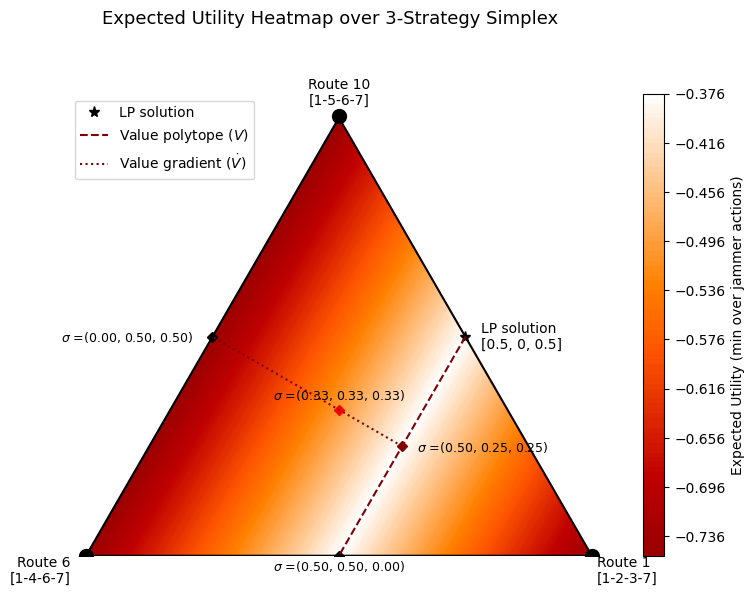

In [26]:
# draw the simplex from (fractions, values):

polytope = np.array([[0.5, 0, 0.5],
                     [0.5, 0.5, 0]])
gradientline = np.array([[0.5, 0.25, 0.25],
                         [0, 0.5, 0.5]])
# marker format [sigA, sigB, sigC, color, position NESW]
markers = [[0.333, 0.333, 0.333, 'red', 'north'],
           [0.5, 0.25, 0.25, 'maroon', 'east'],
           [0.5, 0.5, 0, 'black', 'south'],
           [0, 0.5, 0.5, 'black', 'west']]


plot_simplex_heatmap_with_labels(fractions, values, points=markers, polytope=polytope, gradient=gradientline)